In [1]:
# Install YOLOv11 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 15.4 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='8a1b95ea42f6c41ac024eae0d344b48f4b62a3f4')

In [3]:
# Define paths
root_dir = '/kaggle/input/toothdecaydetection'
v1_dir = os.path.join(root_dir, '/kaggle/input/toothdecaydetection')

In [4]:
# Ensure the YOLOv11 data directories exist
os.makedirs('yolov11/data/caries_v1', exist_ok=True)

Displaying some training images from version 1:


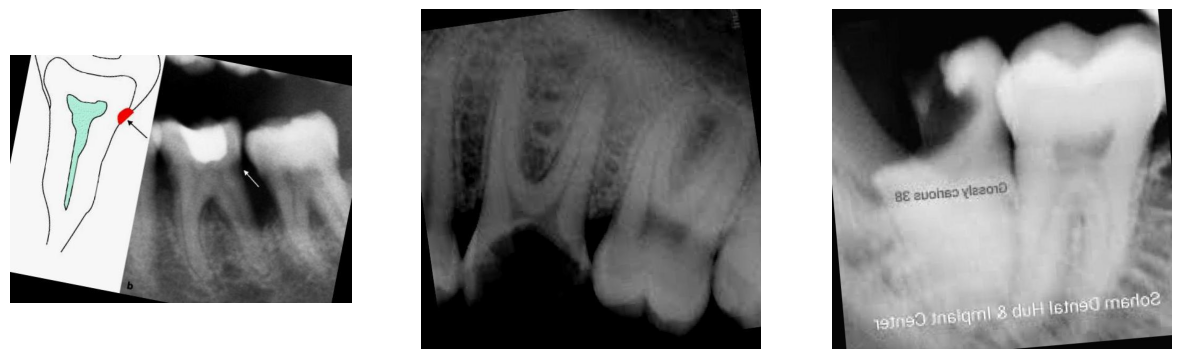

In [5]:
# Function to display images
def display_images(image_dir, num_images=3):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

In [6]:
# Copy dataset to YOLOv11 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov11/data/caries_v1')

In [7]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov11/data/caries_v1/data.yaml', '/kaggle/working/yolov11/data/caries_v1')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov11/data/caries_v1/data.yaml')



Updated data.yaml for version 1:
train: /kaggle/working/yolov11/data/caries_v1/train/images
val: /kaggle/working/yolov11/data/caries_v1/valid/images
test: /kaggle/working/yolov11/data/caries_v1/test/images

nc: 2
names: ['Dentin_Caries', 'Pulpitis_Caries']

roboflow:
  workspace: cocoyaml
  project: tooth-decay-dectection-6hjk3-lvwpt
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cocoyaml/tooth-decay-dectection-6hjk3-lvwpt/dataset/1


In [8]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))


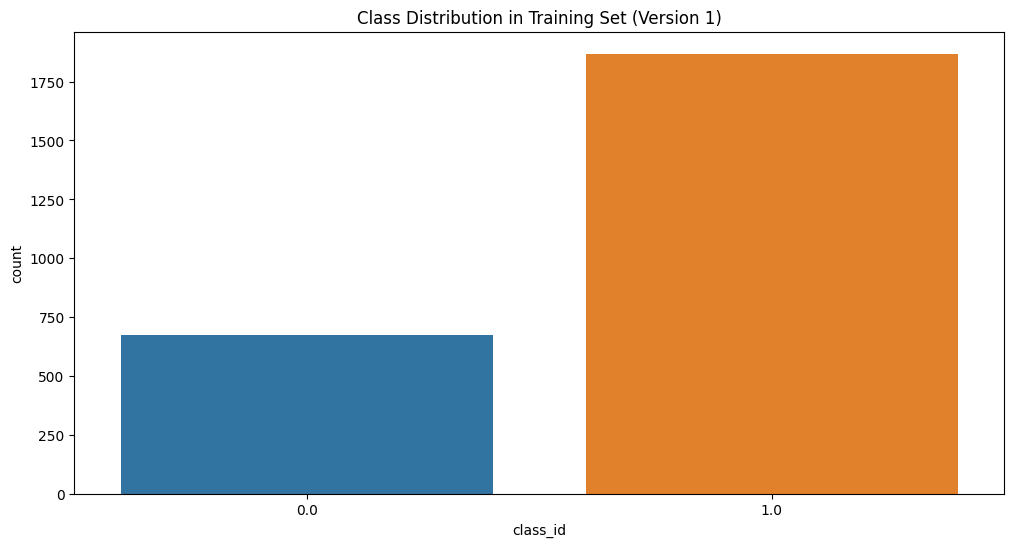

In [9]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

In [10]:
AUGMENTATION = False

if AUGMENTATION:
    augment_transform = Compose([
        HorizontalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
    ], bbox_params={'format': 'yolo', 'label_fields': ['labels']})

    def augment_images(destination_folder, minority_classes, num_aug=5):
        label_folder = os.path.join(destination_folder, 'labels')
        image_folder = os.path.join(destination_folder, 'images')

        for label_file in os.listdir(label_folder):
            label_path = os.path.join(label_folder, label_file)
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(image_folder, image_file)

            if not os.path.exists(image_path):
                continue

            # Đọc nhãn
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Kiểm tra xem ảnh này có chứa lớp thiếu hay không
            contains_minority = False
            labels = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(parts[0])
                if class_id in minority_classes:
                    contains_minority = True
                labels.append(parts)

            if not contains_minority:
                continue

            # Đọc ảnh
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Chuyển đổi labels thành list of dicts cho albumentations
            bboxes = []
            bbox_labels = []
            for parts in labels:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                bboxes.append([x_center, y_center, width, height])
                bbox_labels.append(class_id)

            # Áp dụng augmentations và lưu lại
            for i in range(num_aug):
                augmented = augment_transform(image=image, bboxes=bboxes, labels=bbox_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['labels']

                if not aug_bboxes:
                    continue  # Nếu không còn bounding boxes sau augmentation

                # Lưu ảnh đã augment
                aug_image_file = label_file.replace('.txt', f'_aug_{i}.jpg')
                aug_image_path = os.path.join(image_folder, aug_image_file)
                cv2.imwrite(aug_image_path, aug_image)

                # Chuyển đổi bounding boxes sang định dạng YOLO và ghi lại
                aug_label_file = label_file.replace('.txt', f'_aug_{i}.txt')
                aug_label_path = os.path.join(label_folder, aug_label_file)
                with open(aug_label_path, 'w') as f:
                    for bbox, cls_id in zip(aug_bboxes, aug_labels):
                        f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

        print("Data augmentation completed.")

    # Áp dụng augmentations cho các lớp thiếu
    threshold = 25000
    minority_classes = [cls for cls, count in train_class_count.items() if count < threshold]
    print("Minority Classes:", minority_classes)

    augment_images(train_folder, minority_classes, num_aug=5)

    # Tạo lại danh sách file sau khi augment
    train_image_files = os.listdir(os.path.join(train_folder, 'images'))
    train_label_files = os.listdir(os.path.join(train_folder, 'labels'))

    print(f"Train set after augmentation: {len(train_image_files)} images")

In [11]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 15.6MB/s]


In [12]:
# Train model on version 1 dataset
#AUGMENT = True
model.train(data='/kaggle/input/toothdecaydetection/data.yaml',  # Path to dataset
epochs=200, 
    imgsz=640, 
    batch=16, 
    name='caries_v1_aug',
    lr0=0.0001,                   # Further reduced initial learning rate
    lrf=0.2,                     # Final learning rate scaling factor
    hsv_h=0.015,                 # Hue variation for augmentation
    hsv_s=0.7,                   # Saturation variation for augmentation
    hsv_v=0.4,                   # Value variation for augmentation
    degrees=0.0,                 # No rotation
    translate=0.1,               # Slight translation for generalization
    scale=0.6,                   # Scaling for small object variation
    shear=0.0,                   # No shear
    perspective=0.0,             # No perspective change
    flipud=0.2,                  # Vertical flip probability
    fliplr=0.5,                  # 50% chance for horizontal flip
    mosaic=0.65,                 # Slight increase in mosaic augmentation
    mixup=0.1,                   # Add light mixup for variability
    cls=1.2,                     # Adjusted class loss weight
    box=2.5,                     # Maintain current box loss weight
    save_period=3,               # Save checkpoint every 3 epochs
    verbose=True                 # Output true
)



Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/toothdecaydetection/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=3, cache=False, device=None, workers=8, project=None, name=caries_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 3.59MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/toothdecaydetection/train/labels... 1764 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:02<00:00, 881.04it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/toothdecaydetection/valid/labels... 169 images, 7 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 552.22it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/caries_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/caries_v1_aug
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.67G     0.7145      8.317      1.998         14        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        169        266       0.73      0.186      0.274      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.69G     0.6755      6.335      1.867         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all        169        266      0.628      0.352      0.443       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.68G      0.664      5.572      1.825          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]

                   all        169        266       0.47      0.373      0.351       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200       2.7G     0.6618      5.164       1.86          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.505      0.409      0.387      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.68G     0.6506      4.769      1.847          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.515      0.397      0.456      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.67G     0.6477      4.561      1.814          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.656       0.55       0.58      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.67G      0.629      4.303       1.77         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.724      0.539      0.633      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.68G     0.6352      4.215      1.796          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.682      0.479      0.602      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.68G     0.6398      4.277      1.783          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        169        266      0.682      0.589      0.623      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.67G     0.6379      4.235      1.802         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266        0.6      0.634      0.627      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.67G     0.6177       4.03       1.75          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]

                   all        169        266      0.562      0.612      0.617      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.68G     0.6273      4.041      1.783         20        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        169        266       0.63      0.621      0.614      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.68G     0.6225      3.954      1.743          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.632       0.62      0.644      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.66G     0.6191      3.833      1.748          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.648      0.563      0.619      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.67G      0.609      3.762      1.749          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        169        266      0.656      0.665      0.673      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.67G     0.6146      3.836      1.755         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        169        266      0.662      0.558      0.633      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.67G     0.6077      3.645      1.715          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.635      0.638      0.658      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.66G     0.6123      3.672       1.73          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.671      0.678      0.679       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.72G     0.6139      3.731      1.726         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.763       0.67      0.734      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.67G      0.606      3.664      1.726         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266       0.66      0.677      0.692      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.66G      0.605      3.585       1.71          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.675      0.576      0.641      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.67G     0.6067      3.483      1.703          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.723      0.647      0.641       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.69G     0.5959      3.446      1.701         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]

                   all        169        266      0.629      0.607      0.611      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.71G     0.5988       3.49      1.697         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.694      0.632      0.675      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.66G     0.6036      3.368       1.71          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266       0.75      0.652      0.715      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.67G     0.5943      3.384      1.684         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        169        266      0.728      0.686      0.721      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.67G     0.6031      3.458      1.701          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.799      0.674      0.725      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       2.7G     0.5891      3.333      1.678         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all        169        266      0.767      0.643      0.705      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.69G     0.5942      3.411      1.674          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.758      0.678      0.707      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.68G     0.5848      3.341      1.674         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        169        266      0.759      0.691      0.744      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.67G     0.5811      3.225      1.659          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.742      0.708      0.729      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       2.7G     0.5892      3.223       1.66         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        169        266      0.743      0.701      0.736      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.69G     0.5863      3.315      1.669          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        169        266      0.778      0.706      0.755       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.67G     0.5822      3.223      1.653         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.733       0.69      0.697      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.67G      0.578      3.117      1.646          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.754      0.674      0.706      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.67G     0.5874      3.277      1.661          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        169        266      0.813      0.688      0.733      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.66G     0.5888      3.255      1.663         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.821      0.674      0.748       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       2.7G     0.5874      3.236      1.662          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.784      0.685      0.725      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.67G     0.5793      3.095      1.637          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.821      0.688      0.746      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.67G      0.577      3.179      1.636         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.667      0.717      0.732      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.67G     0.5787      3.147      1.638         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.766      0.719      0.775      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       2.7G     0.5701      3.126      1.618          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        169        266      0.794      0.737       0.77      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.69G     0.5694      3.093       1.62          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]

                   all        169        266      0.846       0.68      0.747      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.71G     0.5696      3.116      1.618          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]

                   all        169        266      0.724      0.705      0.722      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.67G     0.5715      3.032      1.632          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.818      0.744      0.786      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.67G     0.5637      2.983      1.616          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.739      0.716      0.761      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.71G     0.5617      2.992      1.618          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

                   all        169        266      0.749      0.714      0.729      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.68G     0.5688      3.002      1.625         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.783      0.751      0.784      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.69G     0.5635      3.002      1.616         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        169        266        0.8      0.719      0.776      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.67G     0.5714      3.096      1.638          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.814      0.763      0.788      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.67G     0.5734      3.091      1.626          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266      0.783      0.722       0.77      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.66G      0.563      2.924      1.602          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.837      0.789      0.814      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.67G      0.559       2.93      1.594         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

                   all        169        266      0.823       0.71      0.786      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.66G     0.5594      2.955      1.601          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.833      0.715      0.784      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.67G     0.5717      2.955      1.625          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.786      0.725      0.768      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.67G     0.5608      2.986      1.614         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]

                   all        169        266       0.74       0.78      0.797       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.69G     0.5705      2.999      1.635         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.768      0.729      0.754       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.67G     0.5614      2.977      1.623          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.832      0.756      0.806      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.67G     0.5575      2.915      1.601         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.801      0.777      0.809      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.68G     0.5622      2.931      1.625          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

                   all        169        266      0.798      0.724      0.765      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.68G     0.5602      2.967      1.617          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.795      0.777      0.809       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.66G     0.5582      2.918      1.625          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.802      0.787      0.815      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.69G     0.5582      2.872      1.598         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266      0.763      0.757      0.777      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       2.7G     0.5419      2.745      1.562          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.808      0.715      0.768       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.67G     0.5614      2.849        1.6         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.771      0.762      0.765      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.67G     0.5566      2.859      1.601          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266       0.81      0.759      0.803      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.69G     0.5489      2.775      1.585          2        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        169        266      0.817      0.786      0.777      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.68G      0.556      2.812      1.601          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.748      0.761      0.761      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.69G     0.5578      2.937      1.604         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.719      0.719      0.746      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.67G      0.556      2.889      1.581          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        169        266      0.797      0.742      0.788      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.67G     0.5505      2.824      1.587          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        169        266      0.871      0.695      0.778      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.68G     0.5513      2.725      1.577          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.798      0.716      0.774      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.67G     0.5517      2.782      1.591          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.807       0.77      0.798      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.68G     0.5512      2.812      1.577          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all        169        266      0.781      0.726      0.771      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.69G     0.5483      2.754      1.562          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.755      0.766      0.775      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.68G     0.5474      2.753      1.563         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.804      0.718      0.773       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.67G     0.5466      2.711      1.561         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.848      0.756        0.8      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.68G     0.5424      2.755      1.566         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        169        266      0.788      0.764      0.799      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.69G     0.5432      2.709       1.57          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        169        266      0.801        0.7      0.767      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.68G     0.5392      2.735      1.557         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.831      0.782      0.809      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.68G      0.547      2.753      1.576          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        169        266      0.828      0.771      0.809      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.67G     0.5451      2.764      1.562          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266        0.8      0.752      0.791      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.71G     0.5394      2.659      1.549         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.812      0.734      0.783      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       2.7G     0.5471      2.643      1.567         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.833      0.761      0.804      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.67G      0.534      2.699      1.545          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.818      0.757      0.791      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.68G     0.5465      2.702      1.559          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266       0.81      0.738      0.776      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.67G     0.5379      2.686      1.538          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.834      0.786      0.818      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.68G     0.5345      2.649      1.549          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266      0.844      0.728      0.791      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       2.7G     0.5406      2.643      1.558         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]

                   all        169        266      0.783      0.801      0.796      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.67G     0.5419      2.681      1.562         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        169        266      0.743      0.766      0.767      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.67G     0.5366      2.724      1.542          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

                   all        169        266      0.852      0.718      0.807      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.67G      0.539      2.654      1.535         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.772       0.78      0.797        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.67G      0.532      2.596      1.538          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.827      0.757      0.826      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       2.7G     0.5348      2.619      1.525          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]

                   all        169        266      0.812      0.789      0.821      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.69G     0.5318      2.567      1.538         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.831      0.779      0.799        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.68G     0.5299      2.562      1.529          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.786      0.796       0.83        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.68G     0.5401      2.617      1.538         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.801      0.791      0.809      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       2.7G     0.5336      2.601      1.529         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.807      0.747      0.787      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.67G     0.5246      2.565      1.521          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.837      0.784      0.824      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.68G     0.5242      2.484      1.514         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]

                   all        169        266      0.805      0.766      0.796      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.67G     0.5342      2.607      1.534         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.786      0.806      0.798      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.67G     0.5315      2.541      1.516          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.828      0.757      0.776      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.69G     0.5307      2.533      1.523         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.793      0.783      0.793      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.66G     0.5268      2.559      1.519          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.808      0.816      0.807      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.67G     0.5257      2.539       1.51          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.823      0.791      0.815      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       2.7G     0.5268      2.541      1.501         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        169        266      0.833      0.784      0.822      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.67G     0.5276      2.508      1.516         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.829      0.762        0.8      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.68G     0.5299      2.572      1.517          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        169        266      0.801      0.786      0.808      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.69G     0.5348      2.631      1.528         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.779      0.745      0.777      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.67G     0.5227      2.516      1.502          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266        0.8      0.775      0.802      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.69G     0.5239      2.519       1.49          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        169        266       0.84      0.785      0.786      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.69G     0.5227      2.451      1.518         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

                   all        169        266      0.835      0.774      0.804        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.69G     0.5305      2.528      1.507          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.832       0.78      0.811      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.66G     0.5256      2.497      1.517         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        169        266      0.792      0.772      0.805      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.69G     0.5211      2.424      1.501          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        169        266      0.828      0.789      0.808      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.68G     0.5183      2.408      1.493          2        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        169        266      0.813        0.8      0.799      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.68G     0.5117      2.397      1.483          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        169        266      0.796      0.812      0.814      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.67G     0.5135      2.397       1.49          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.766      0.804      0.811      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.72G     0.5128      2.458      1.482         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        169        266      0.833      0.783      0.804      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.68G     0.5221      2.458      1.504         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]

                   all        169        266      0.812       0.78      0.807      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.71G     0.5241      2.483      1.515         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        169        266      0.793      0.777        0.8      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.68G     0.5147      2.413      1.484         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

                   all        169        266      0.859      0.747      0.802      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.72G     0.5162      2.439      1.499          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266       0.83      0.757      0.807      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.68G     0.5133      2.464      1.484          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.796      0.762       0.79       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.69G     0.5139      2.385      1.488          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.791      0.803      0.811      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.66G     0.5133      2.402      1.478          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.824      0.823      0.839      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.67G     0.5171      2.353      1.477         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        169        266      0.816      0.795      0.828      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.71G     0.5159      2.381      1.491          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.838      0.767      0.815      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.67G     0.5193      2.362      1.489          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        169        266      0.796       0.78        0.8      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.65G     0.5103      2.343      1.469          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        169        266      0.831      0.791      0.819      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.69G     0.5079      2.326      1.466         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]

                   all        169        266       0.85      0.742      0.804      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.68G     0.5078      2.363      1.472         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.833      0.834      0.827      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.69G     0.5034      2.302      1.459          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.824      0.789      0.816      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       2.7G     0.5078      2.334      1.452         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all        169        266      0.839      0.814      0.817      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.67G     0.5062      2.368       1.48         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266       0.81      0.789      0.809      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.67G      0.513      2.456      1.487         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        169        266      0.813      0.802      0.824      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.69G     0.5041      2.337      1.463         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        169        266      0.792      0.799      0.815      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.67G     0.5098      2.356      1.478          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.809      0.765       0.81      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.67G     0.5019      2.331      1.462         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.823      0.795      0.809      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.67G     0.5015        2.3      1.458         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.826       0.76      0.801      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.67G     0.5061      2.348       1.46         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

                   all        169        266      0.814      0.771      0.802      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.66G     0.4983      2.279      1.451         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        169        266      0.832      0.762      0.812      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.69G      0.502      2.261      1.454          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266      0.825      0.807      0.818      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.67G     0.5029      2.285      1.456         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266       0.82      0.797      0.818      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.67G     0.5064      2.329      1.462         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.845      0.786      0.819      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.68G     0.5063      2.265      1.467          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

                   all        169        266      0.811      0.754      0.799      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.69G     0.4996      2.227      1.447         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.807       0.76      0.795      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.68G     0.5051      2.344      1.462         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        169        266      0.834       0.79       0.82        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.69G     0.4988      2.174      1.452          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.857      0.796      0.827      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.67G     0.4977      2.214      1.454          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        169        266      0.822      0.786      0.817      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.69G     0.4945      2.202      1.444         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]

                   all        169        266      0.815      0.783      0.819      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.71G      0.501      2.212       1.46          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.837      0.785      0.823      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.67G     0.5019      2.245      1.461          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.798      0.806      0.812        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.66G      0.496      2.232      1.452          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.842      0.789      0.818      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.67G      0.501      2.236      1.461          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.846      0.765      0.797       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.68G     0.4996      2.252      1.452         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.827      0.771      0.812      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.72G     0.4937      2.235       1.44         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        169        266      0.799      0.784      0.803      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.69G     0.4932      2.212      1.446          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.844      0.792       0.81      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.67G     0.4984      2.223      1.449          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.833      0.765      0.812      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.68G     0.4925      2.254      1.438          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.809      0.777      0.811      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.69G     0.4973      2.231      1.441          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266      0.808      0.777      0.805      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.67G     0.4941       2.15      1.427          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]

                   all        169        266      0.815      0.826      0.832      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.71G     0.4843      2.192      1.429          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.831      0.792      0.826      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.67G     0.4937      2.151      1.436          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.835      0.786      0.838      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.67G      0.497      2.218      1.446         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        169        266      0.829      0.794      0.829      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.68G     0.4917      2.222      1.444         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.815      0.801      0.832      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.69G     0.4892       2.15      1.442         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        169        266      0.821      0.808      0.828      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.68G     0.4898      2.229      1.437         27        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.811      0.773      0.811      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.66G      0.488      2.186      1.442          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266      0.787      0.778      0.811      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.67G     0.4811      2.117      1.421         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.782      0.804      0.821      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.67G     0.4826      2.147      1.423         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        169        266      0.777      0.791      0.818      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.68G     0.4882      2.191      1.427         22        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.809      0.818      0.832      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.69G     0.4825      2.138      1.423         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.813        0.8      0.834       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       2.7G     0.4843      2.138      1.439          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        169        266      0.842      0.794      0.837       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.67G     0.4906       2.13      1.439          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.812      0.806      0.828      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.71G     0.4878      2.131      1.436         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]

                   all        169        266      0.823      0.791      0.825       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.71G     0.4881       2.17      1.437         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        169        266      0.812      0.815      0.827      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.65G     0.4876      2.152      1.425          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.794      0.806      0.821      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.71G     0.4846      2.148      1.422         20        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        169        266      0.812      0.797      0.823      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.67G     0.4822      2.059      1.413          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all        169        266       0.81      0.784      0.816      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.67G     0.4779      2.105      1.404          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        169        266      0.825      0.792      0.816        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.66G     0.4824      2.072      1.402          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.793      0.798       0.82      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.67G     0.4796      2.121      1.415          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.854      0.772      0.814      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.68G     0.4789      2.091      1.394         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]

                   all        169        266      0.818      0.826      0.837      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.69G     0.4873      2.127       1.42          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.804      0.806      0.827      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.67G     0.4786      2.066      1.404          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        169        266      0.787      0.832      0.829      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.69G     0.4771      2.076      1.416          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]

                   all        169        266      0.808       0.82      0.822      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.68G     0.4808      2.135      1.412          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all        169        266      0.824      0.779       0.81      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.68G     0.4816      2.122      1.417          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266      0.801      0.807      0.812      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.67G     0.4744      2.069      1.401         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.864      0.763      0.823      0.412


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.67G     0.4427      1.602      1.372          8        640: 100%|██████████| 111/111 [00:24<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

                   all        169        266      0.839      0.777       0.82      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.66G     0.4403      1.593      1.361          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]

                   all        169        266      0.851      0.731      0.805        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.67G     0.4337      1.569       1.34          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

                   all        169        266      0.872      0.742      0.825      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.65G     0.4372      1.579      1.357          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]

                   all        169        266      0.855      0.748      0.823      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.67G      0.439      1.562      1.358          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.873      0.774      0.827       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.66G     0.4335      1.553      1.347          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all        169        266      0.866      0.768      0.827      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.67G     0.4345      1.546      1.349          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all        169        266      0.862      0.784      0.832      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.65G     0.4324      1.551      1.357          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        169        266      0.872       0.79       0.83      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.67G     0.4307      1.526      1.341          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]

                   all        169        266       0.85      0.795      0.826      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.66G     0.4265      1.543      1.329          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all        169        266      0.888      0.764      0.826      0.404



200 epochs completed in 1.394 hours.
Optimizer stripped from runs/detect/caries_v1_aug/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/caries_v1_aug/weights/best.pt, 5.5MB

Validating runs/detect/caries_v1_aug/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


                   all        169        266      0.822      0.791      0.825      0.421
         Dentin_Caries         54         85       0.76      0.682       0.74      0.356
       Pulpitis_Caries        141        181      0.884      0.901       0.91      0.487


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/caries_v1_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a90d6a70a00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/toothdecaydetection/test/images/1213_jpg.rf.675b8edffbe24fa13d4f250b24b1b8f1.jpg: 640x640 2 Dentin_Cariess, 1 Pulpitis_Caries, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


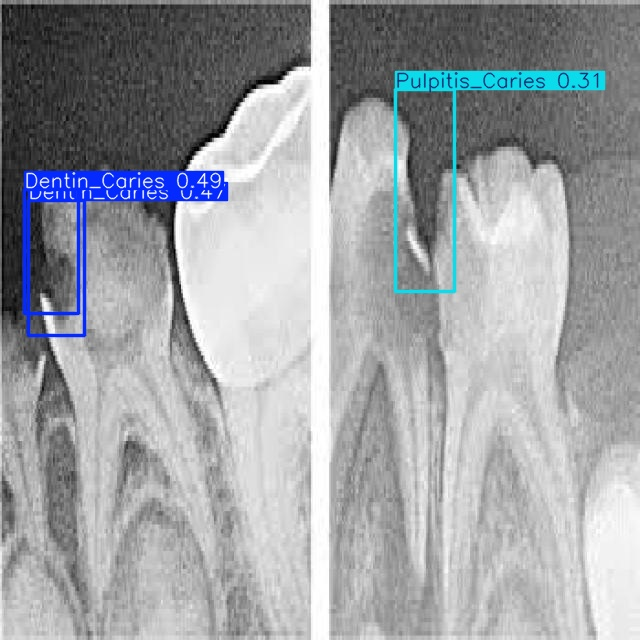


image 1/1 /kaggle/input/toothdecaydetection/test/images/108_jpg.rf.b6781734b689bd8d9397769d7b0e9f2d.jpg: 640x640 (no detections), 8.3ms
Speed: 1.4ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


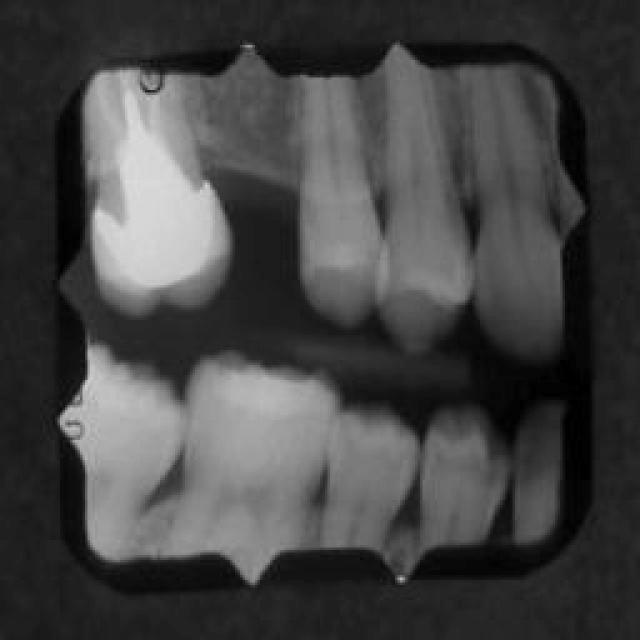


image 1/1 /kaggle/input/toothdecaydetection/test/images/92_jpg.rf.37aaa39ffee2a91758935d5a686a3d17.jpg: 640x640 1 Pulpitis_Caries, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


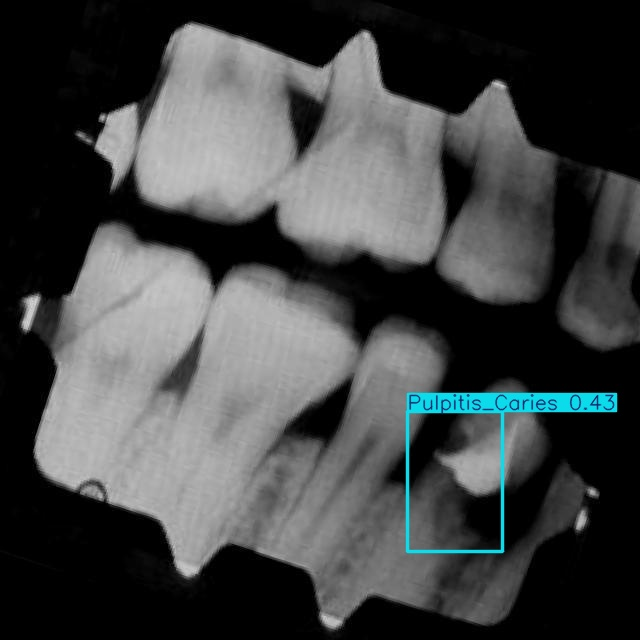


image 1/1 /kaggle/input/toothdecaydetection/test/images/7_png_jpg.rf.e6447ac8726fe19aefb4ba9469fba46d.jpg: 640x640 1 Pulpitis_Caries, 8.1ms
Speed: 1.3ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


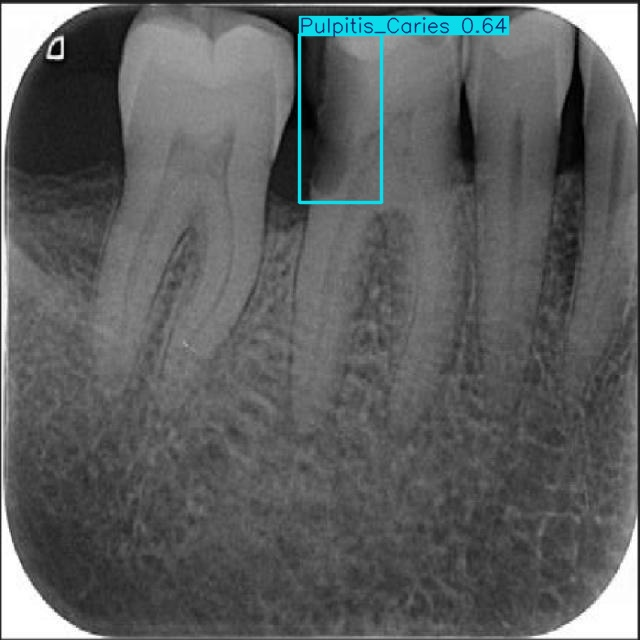


image 1/1 /kaggle/input/toothdecaydetection/test/images/162_png_jpg.rf.a5386671de76c4e431d317888356d26e.jpg: 640x640 1 Pulpitis_Caries, 8.1ms
Speed: 1.2ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


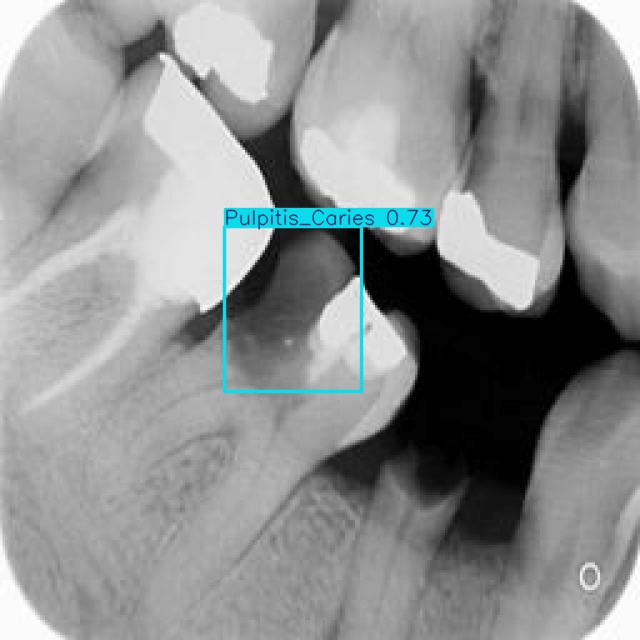

In [13]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model, os.path.join(v1_dir, 'test/images'))


In [14]:
!ls /kaggle/working/runs/detect/caries_v1_aug/

args.yaml					  train_batch1.jpg
confusion_matrix_normalized.png			  train_batch21090.jpg
confusion_matrix.png				  train_batch21091.jpg
events.out.tfevents.1738048970.2acf2438beb0.31.0  train_batch21092.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


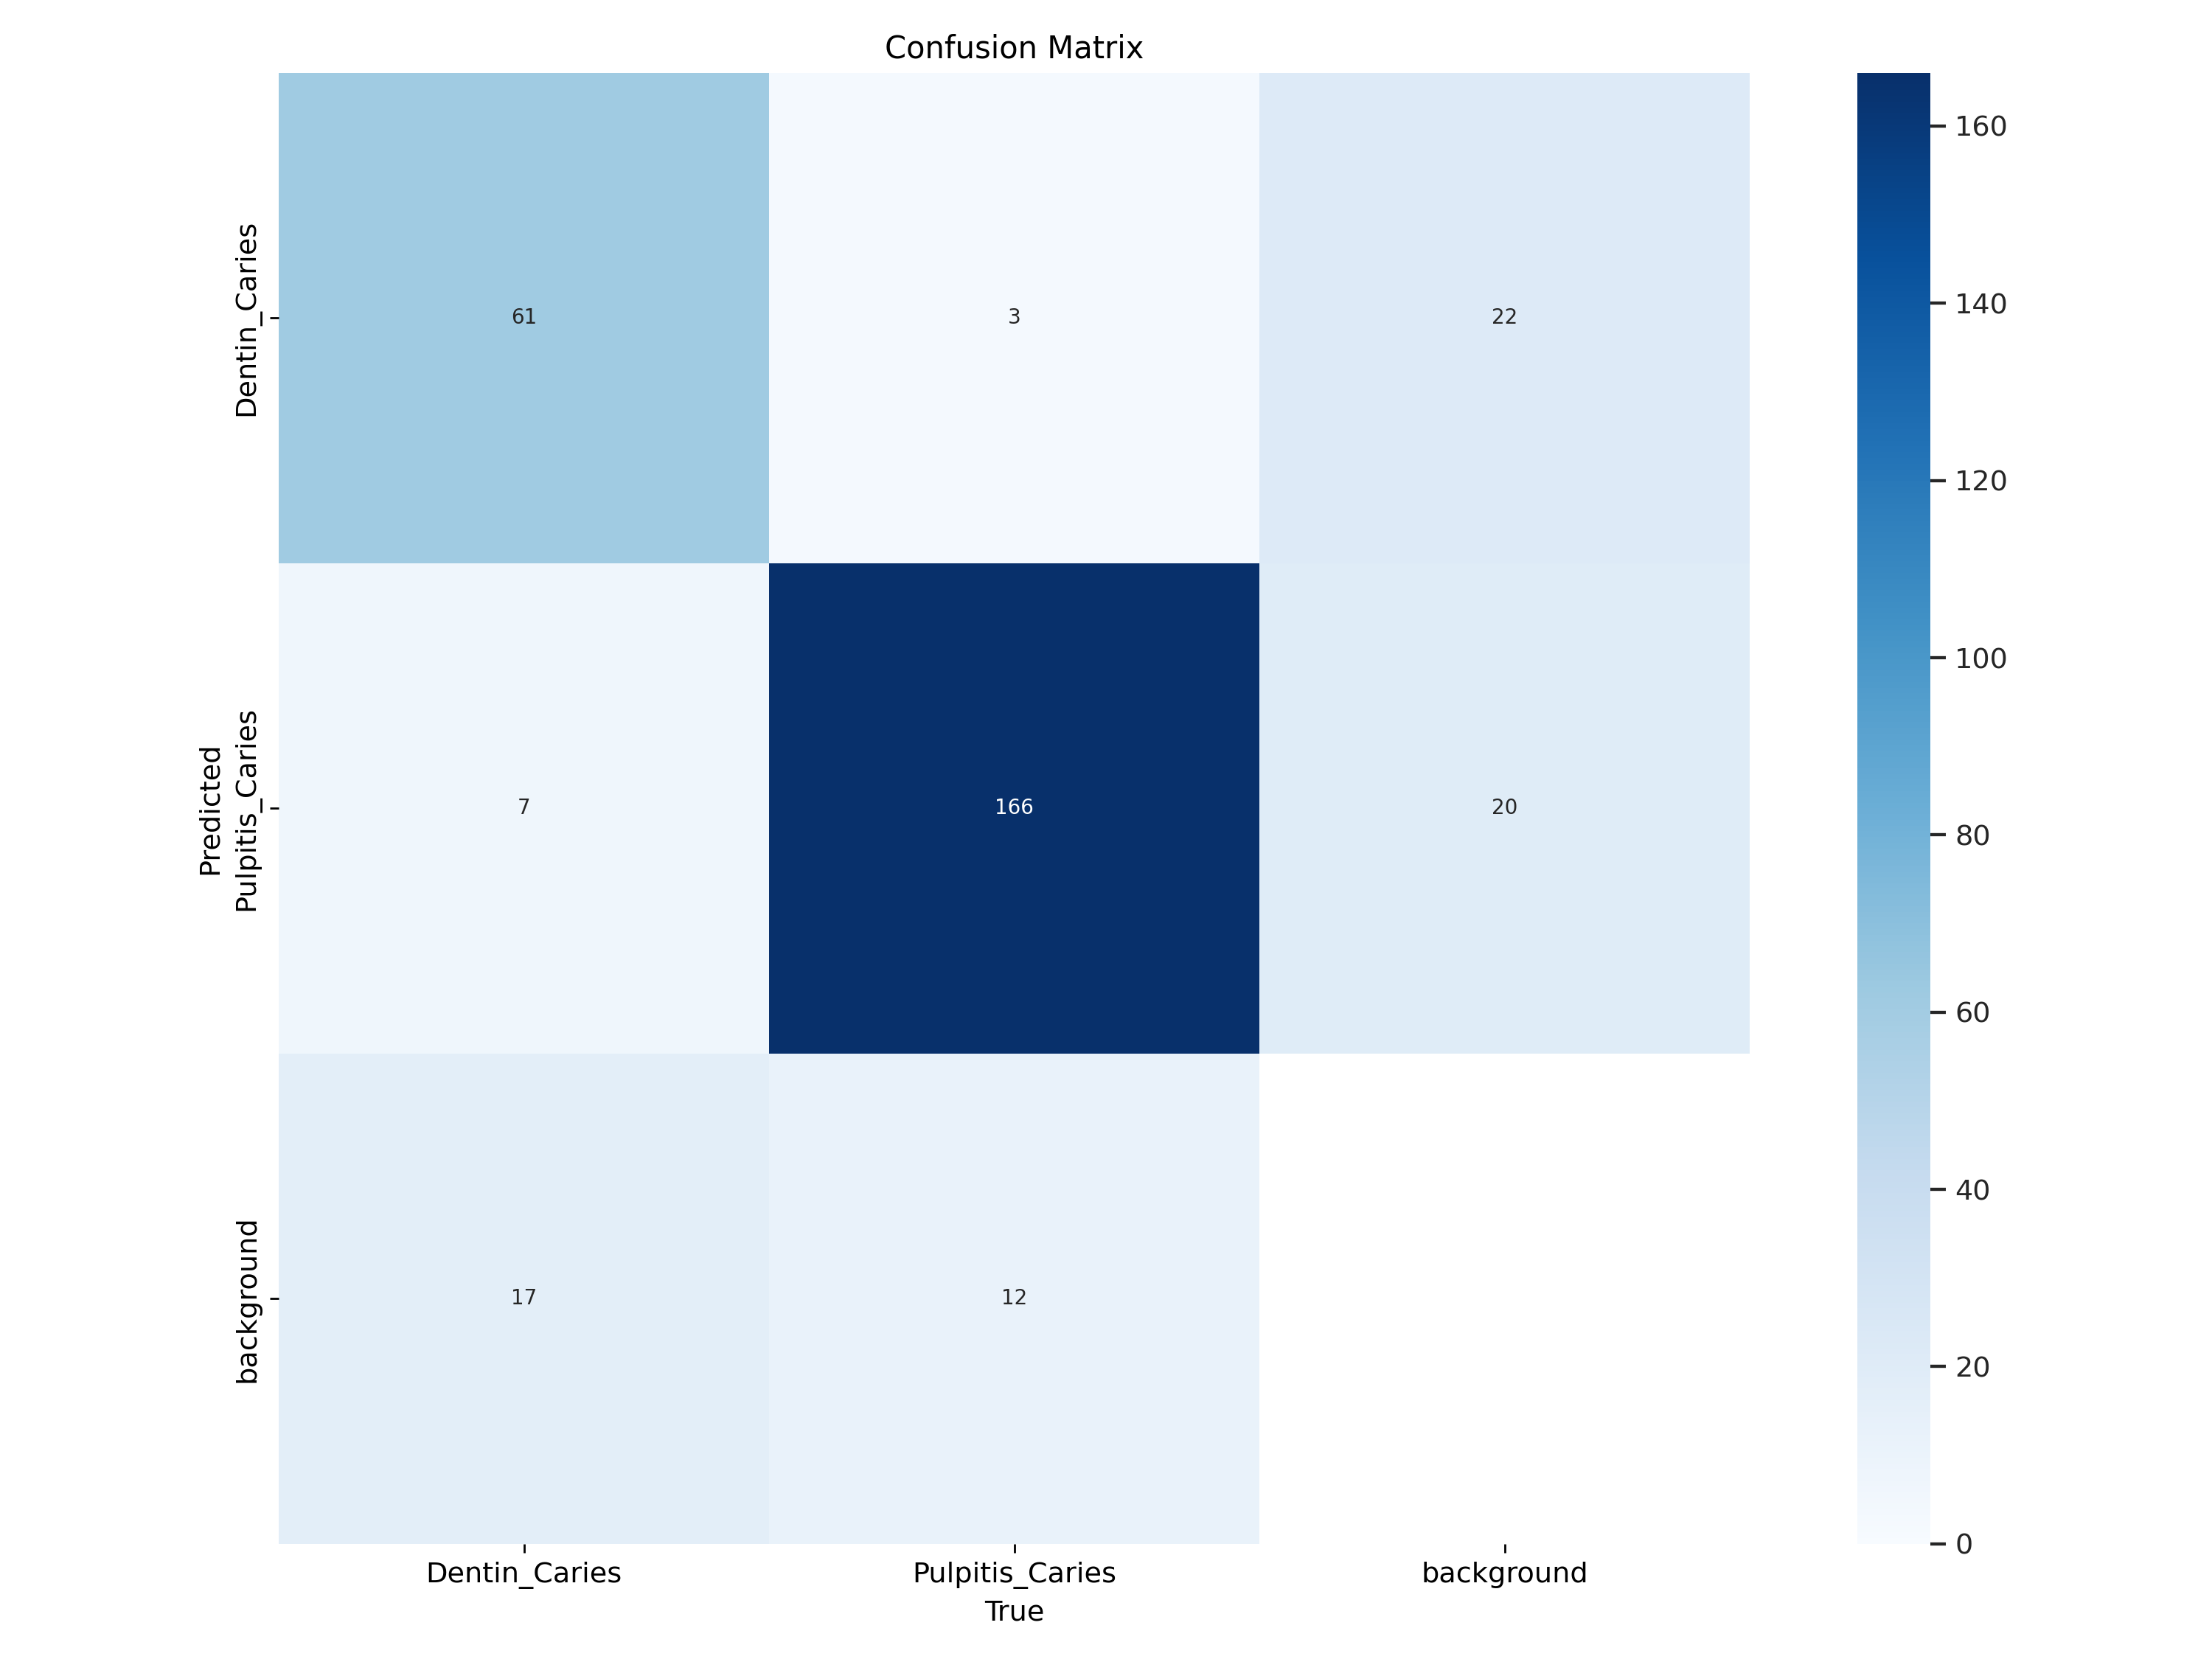

In [15]:
from IPython.display import Image as IPyImage

# Display the confusion matrix image from the specified directory in Kaggle
IPyImage(filename='/kaggle/working/runs/detect/caries_v1_aug/confusion_matrix.png', width=1000)


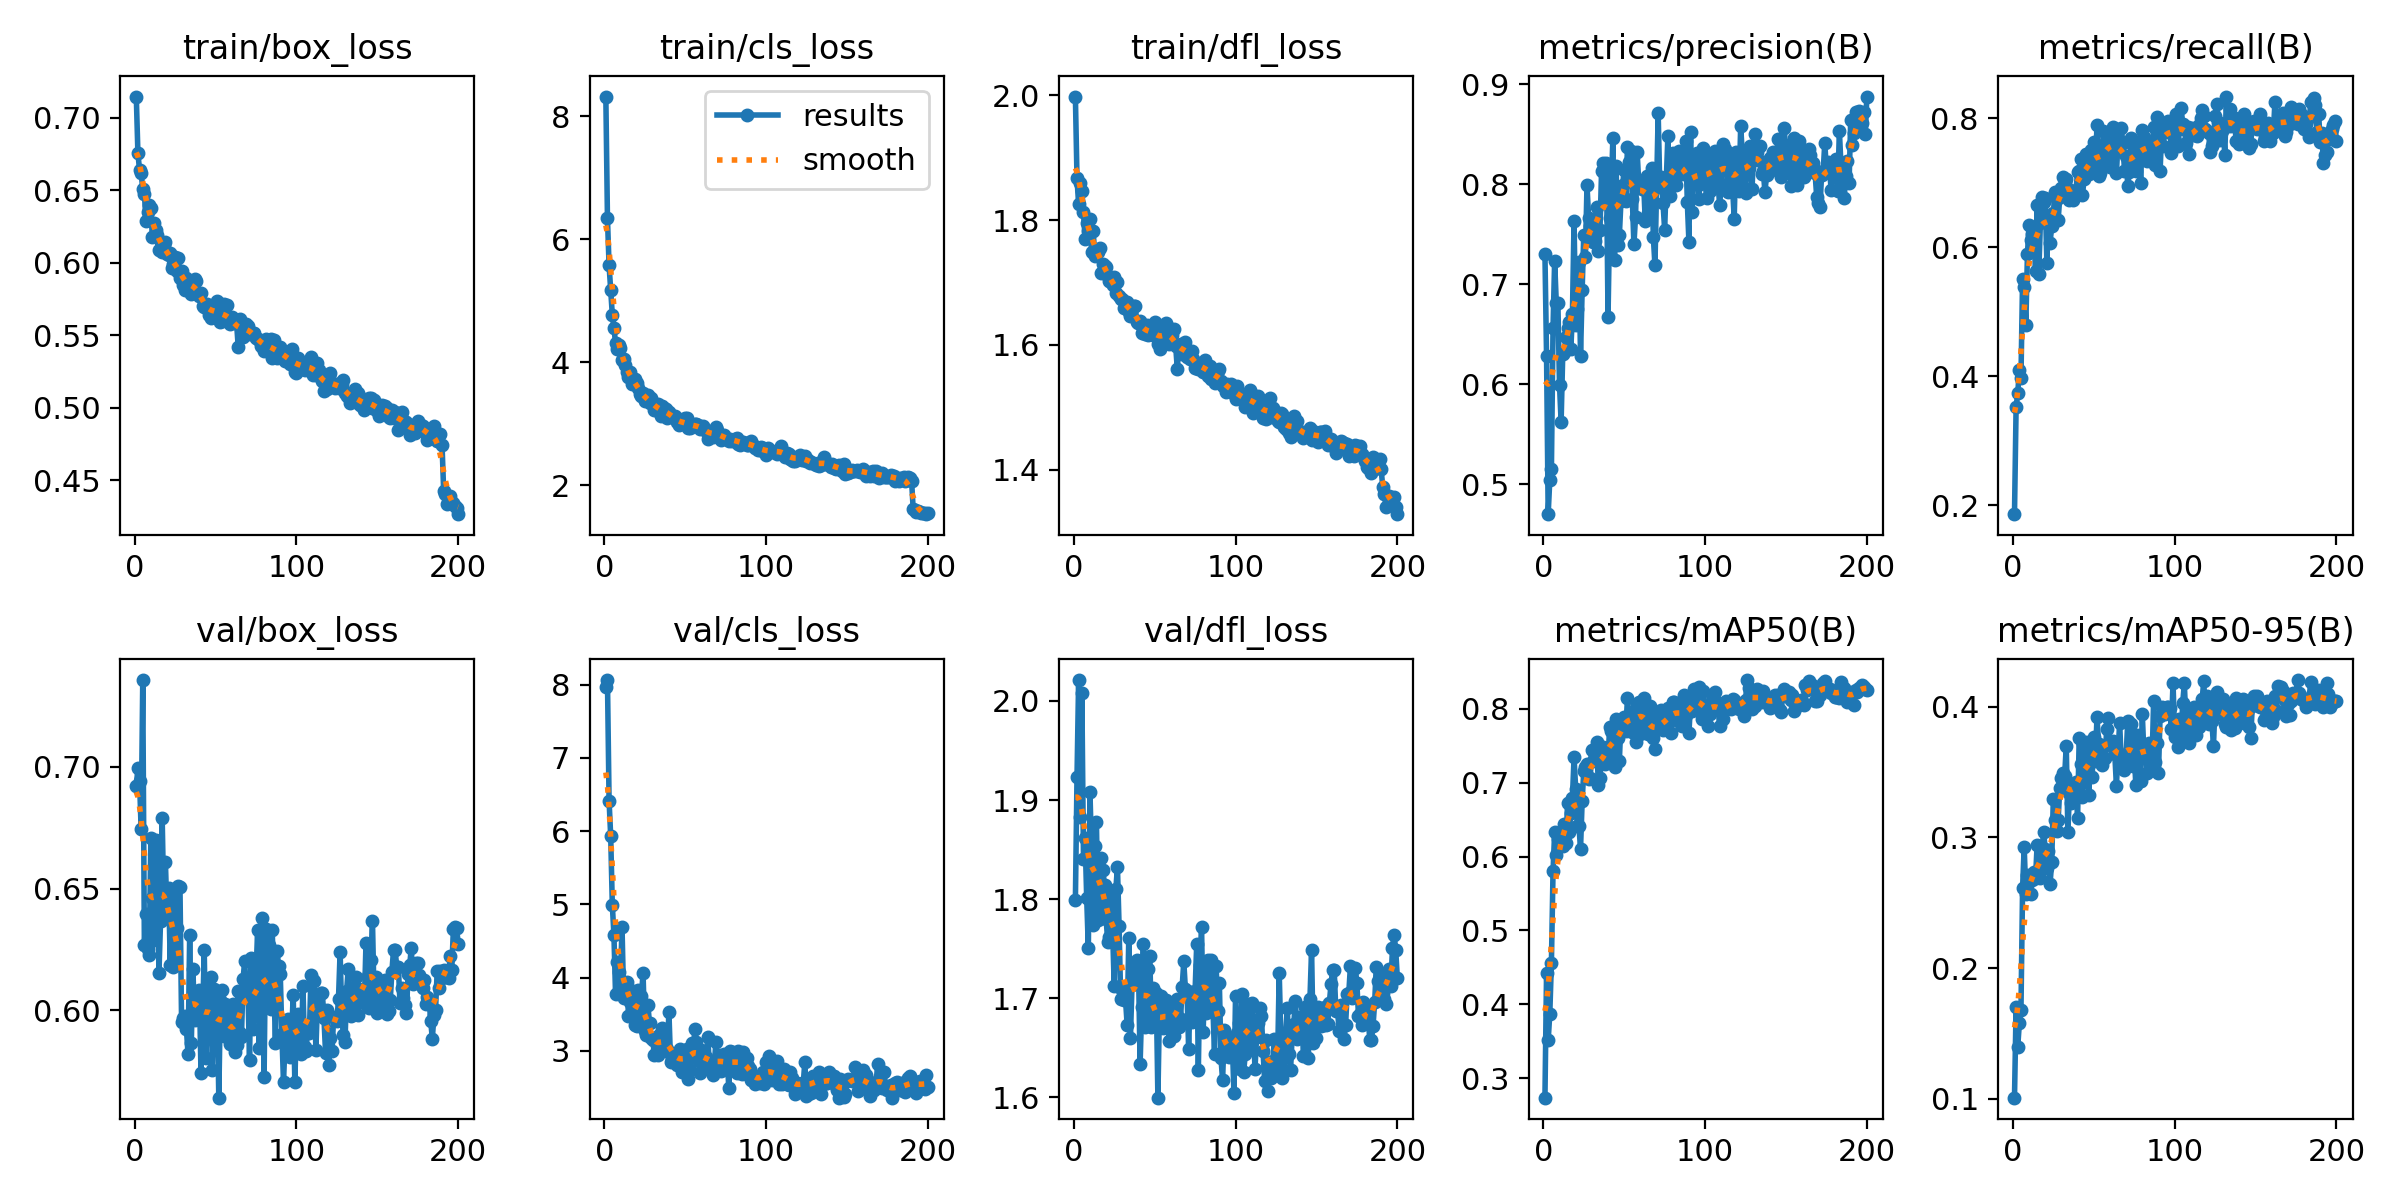

In [16]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/results.png', width=1000)

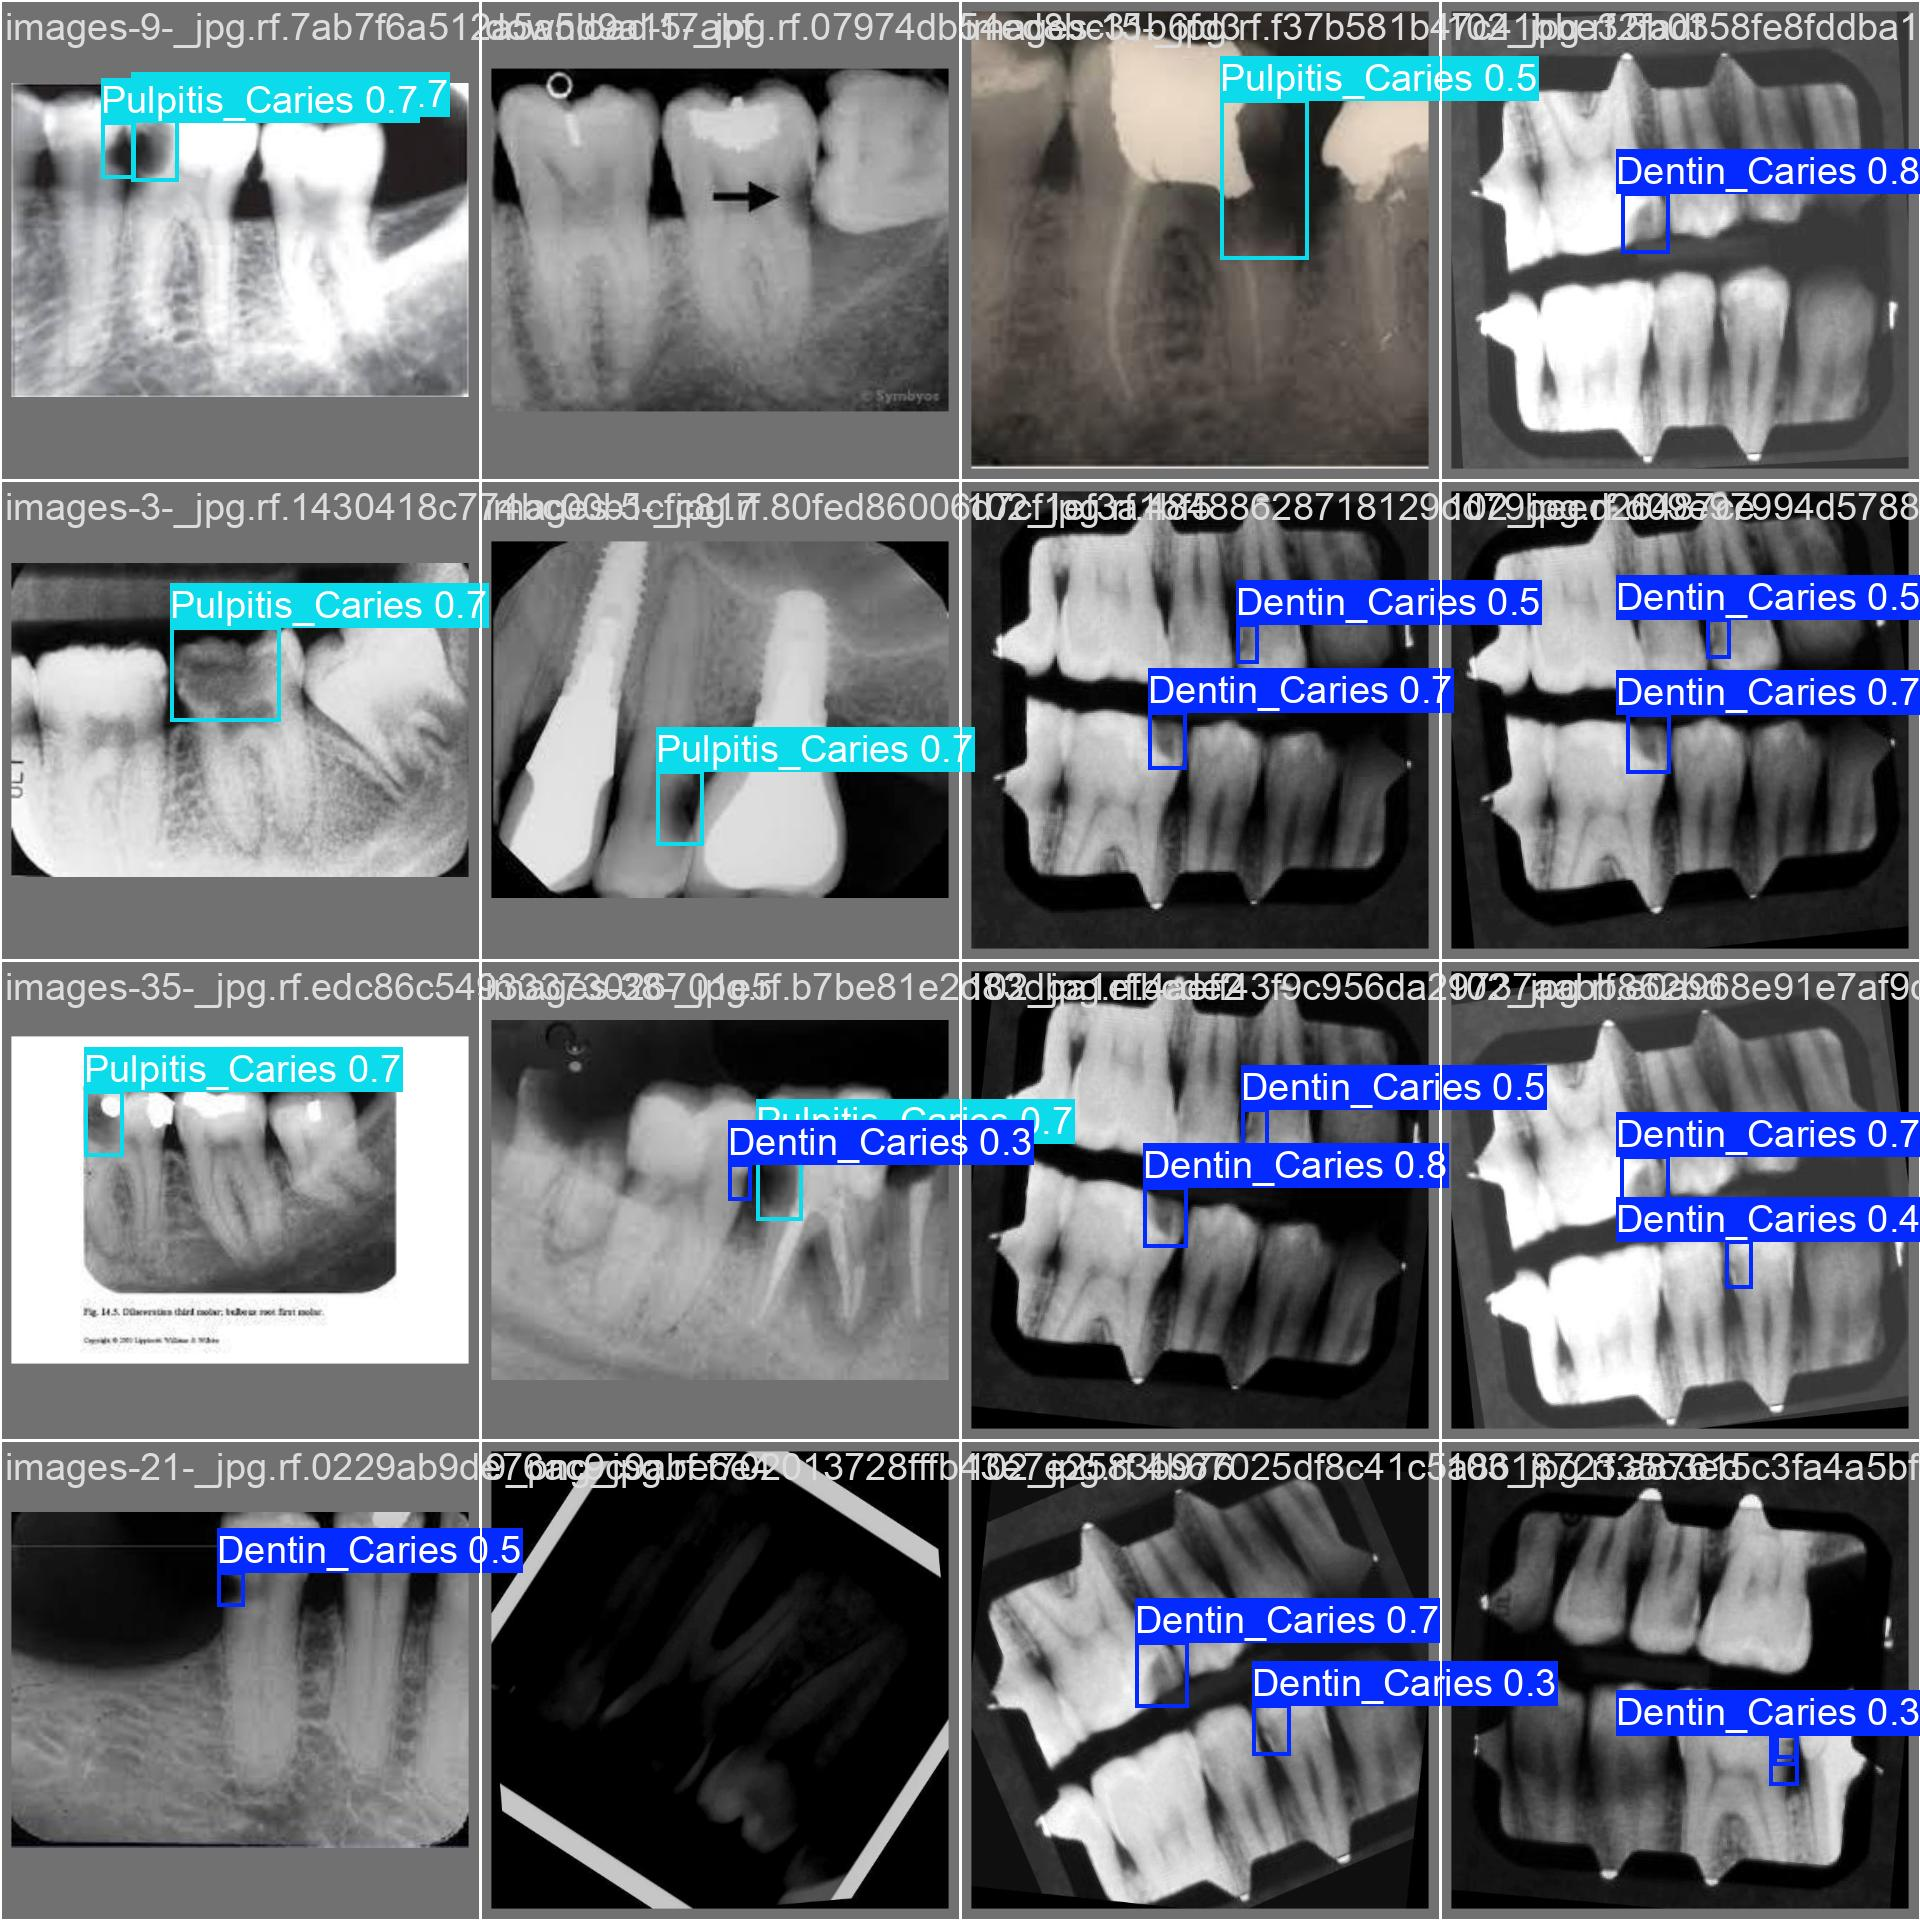

In [17]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/val_batch0_pred.jpg', width=1000)

In [18]:
# Run the validation task using YOLO in Kaggle
!yolo task=detect mode=val model=/kaggle/working/runs/detect/caries_v1_aug/weights/best.pt data=/kaggle/working/yolov11/data/caries_v1/data.yaml

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels... 169 images,
val: New cache created: /kaggle/working/yolov11/data/caries_v1/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        169        266      0.823      0.791      0.825      0.421
         Dentin_Caries         54         85      0.762      0.682      0.741      0.354
       Pulpitis_Caries        141        181      0.885      0.901       0.91      0.487
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 3.1ms inference, 0.

In [19]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
log_file_path = "/kaggle/working/runs/detect/caries_v1_aug/results.csv"
logs = pd.read_csv(log_file_path)  # Read log file into a DataFrame

final_losses = logs.iloc[-1]  # Get the last row

# Print final losses
print("Final Losses:")
print(f"Training Box Loss: {final_losses['train/box_loss']}")
print(f"Training Class Loss: {final_losses['train/cls_loss']}")
print(f"Training DFL Loss: {final_losses['train/dfl_loss']}")
print(f"Validation Box Loss: {final_losses['val/box_loss']}")
print(f"Validation Class Loss: {final_losses['val/cls_loss']}")
print(f"Validation DFL Loss: {final_losses['val/dfl_loss']}")

# Print additional metrics
print("\nFinal Metrics:")
print(f"Precision: {final_losses['metrics/precision(B)']}")
print(f"Recall: {final_losses['metrics/recall(B)']}")
print(f"mAP@50: {final_losses['metrics/mAP50(B)']}")
print(f"mAP@50-95: {final_losses['metrics/mAP50-95(B)']}")

Final Losses:
Training Box Loss: 0.42649
Training Class Loss: 1.54312
Training DFL Loss: 1.32853
Validation Box Loss: 0.6273
Validation Class Loss: 2.50562
Validation DFL Loss: 1.72057

Final Metrics:
Precision: 0.88769
Recall: 0.76412
mAP@50: 0.82595
mAP@50-95: 0.40406


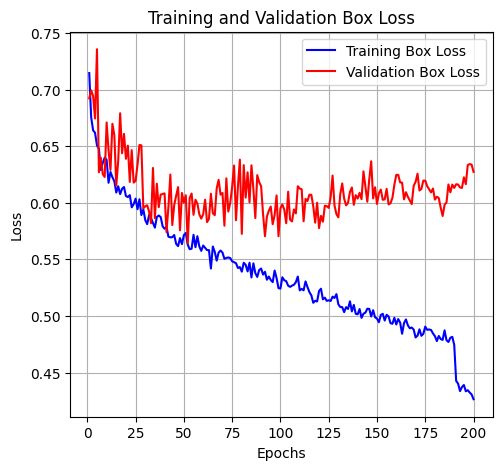

In [20]:
plt.figure(figsize=(12, 5))

# Plot training box loss
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['train/box_loss'], label='Training Box Loss', color='blue')
plt.plot(logs['epoch'], logs['val/box_loss'], label='Validation Box Loss', color='red')
plt.title('Training and Validation Box Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [21]:
path="/kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg"
#prediction on a single image
results = model.predict(source=path,show_labels=False)


image 1/1 /kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg: 640x640 1 Pulpitis_Caries, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


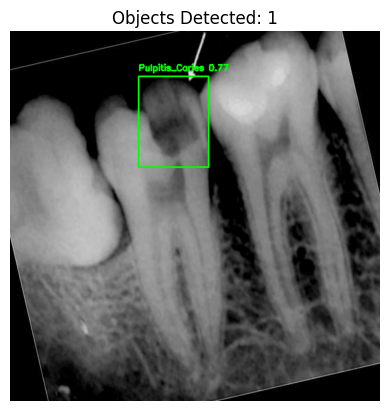

In [22]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(path)

# Loop through detection results
for result in results:
    boxes = result.boxes  # Get the bounding boxes
    for box in boxes:
        # Extract bounding box coordinates, confidence, and class id
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        conf = box.conf[0].item()
        cls = box.cls[0].item()
        
        # Generate label with class name and confidence
        label = f'{model.names[int(cls)]} {conf:.2f}'
        
        # Draw bounding box and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)  # Green text above the box

# Convert BGR image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.title(f"Objects Detected: {len(boxes)}")
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [23]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [25]:
!ls

runs  yolo11n.pt  yolov11  YOLO-V8-CAM


In [26]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [27]:
!pip install ttach

In [28]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [29]:
img = cv2.imread('/kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [30]:
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
    

In [31]:
target_layers =[model.model.model[-4]]

In [32]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 1 Pulpitis_Caries, 129.7ms
Speed: 4.8ms preprocess, 129.7ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)


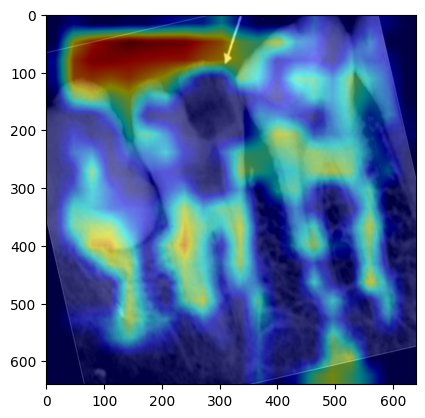

In [33]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [34]:
target_layers =[model.model.model[-3]]


0: 640x640 1 Pulpitis_Caries, 88.9ms
Speed: 2.2ms preprocess, 88.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


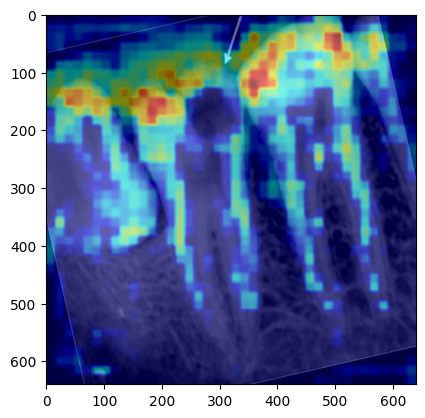

In [35]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [36]:
target_layers =[model.model.model[-4]]



0: 640x640 1 Pulpitis_Caries, 86.2ms
Speed: 2.7ms preprocess, 86.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


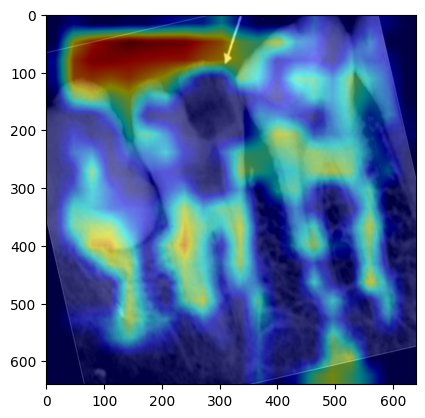

In [37]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

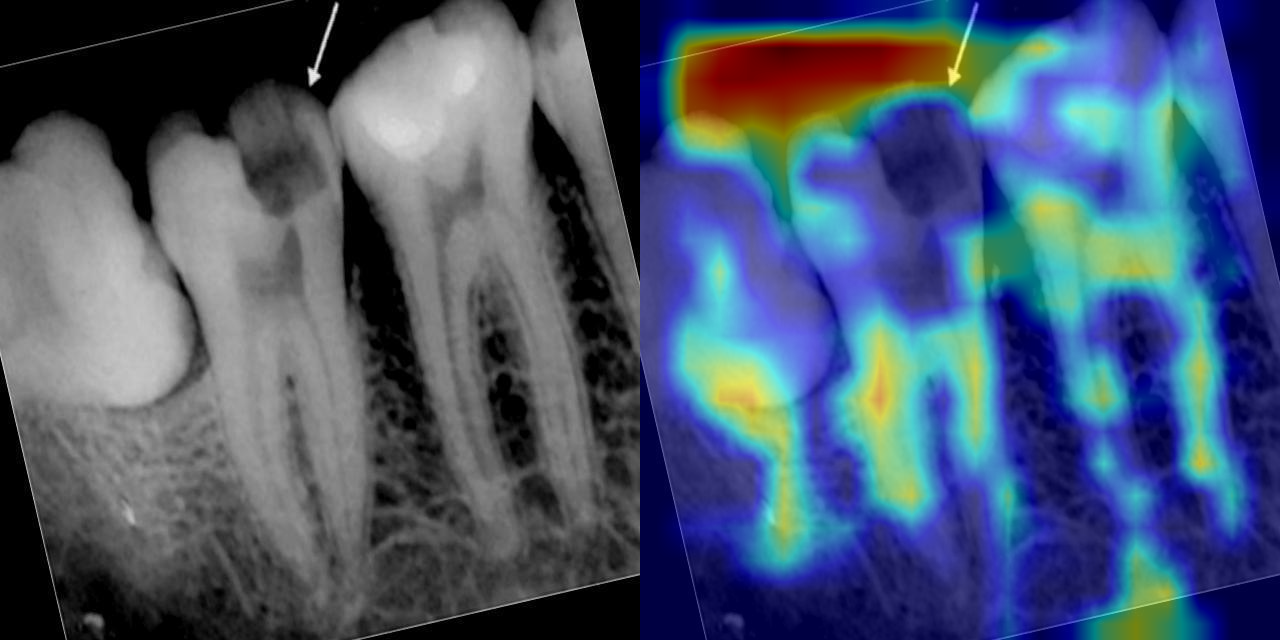

In [38]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [39]:
list_of_metrics = ["R_curve.png", "confusion_matrix.png", "results.png"]

In [40]:
%cd /kaggle/working/

/kaggle/working


In [41]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


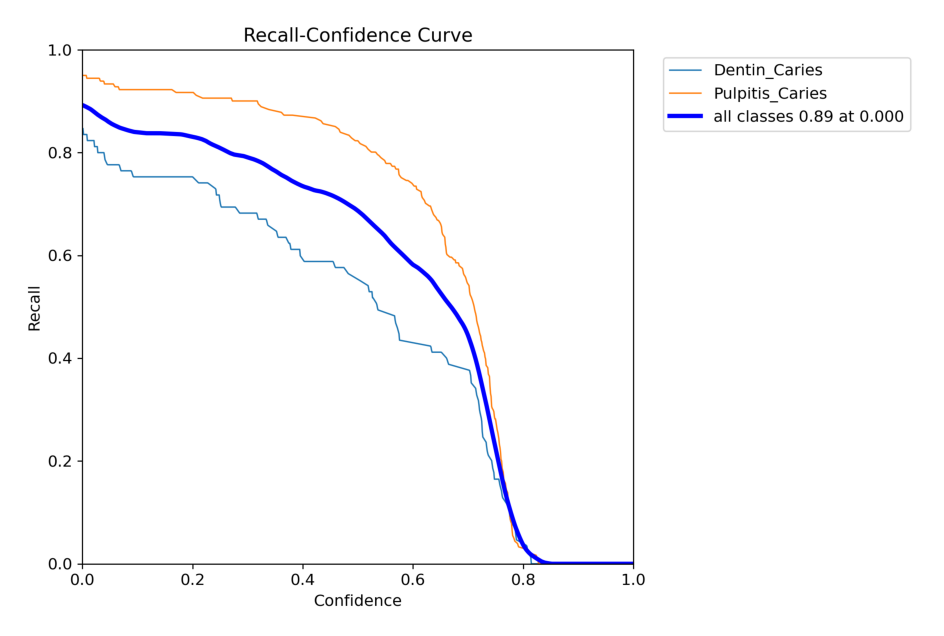

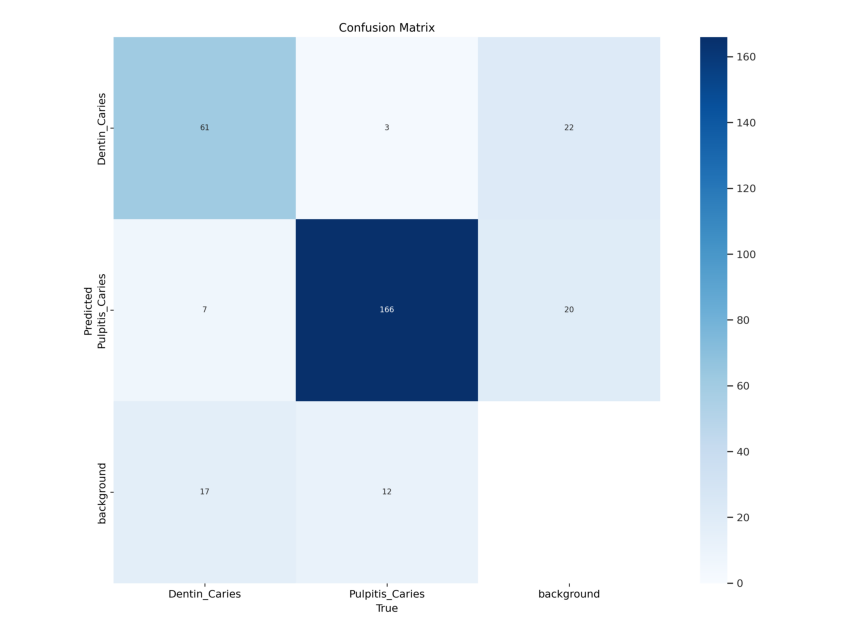

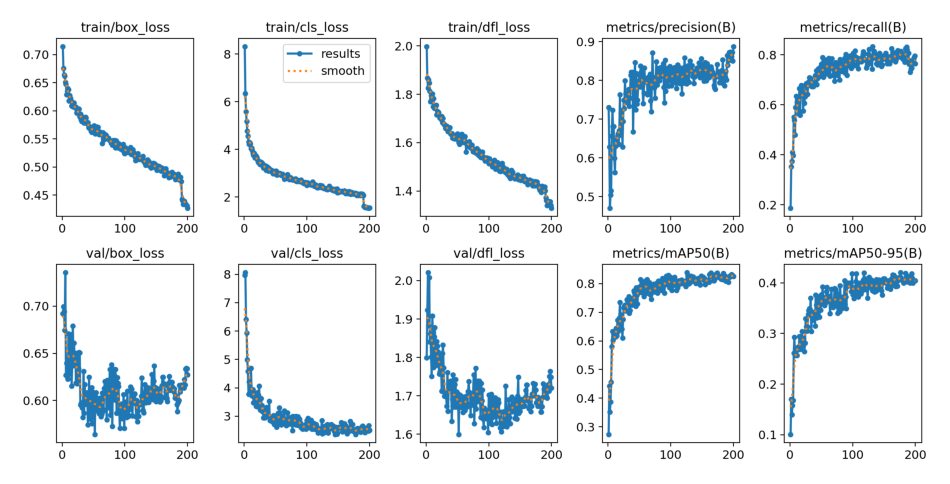

In [42]:
from PIL import Image
for i in list_of_metrics:

    image = Image.open(f'{HOME}/runs/detect/caries_v1_aug/{i}')

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
